# SQLAlchemy Homework - Surfs Up!

#### Import Libraries

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from scipy import stats as st
import datetime as dt

## Step 1 - Climate Analysis and Exploration

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# REFLECT AN EXISTING DATABASE INTO A NEW MODEL
Base = automap_base()

# REFLECT THE TABLES
Base.prepare(engine, reflect=True)

In [4]:
# VIEW THE CLASSES FOUND BY AUTOMAP
engine.table_names()

['measurement', 'station']

In [5]:
# SAVE REFERENCES TO EACH TABLE
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# CREATE OUR SESSION (LINK) FROM PYTHON TO THE DB
session = Session(engine)

In [7]:
# LIST THE CONTENTS OF MEASUREMENT
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# LIST THE CONTENTS OF STATION
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Precipitation Analysis

#### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [9]:
# CALCULATE THE DATE 1 YEAR AGO FROM THE LAST DATA POINT IN THE DATABASE
end_date = dt.datetime.strptime(session.query(Measurement.date)[-1:][0][0],'%Y-%m-%d')
end_date = dt.date((end_date).year, (end_date).month, (end_date).day)
start_date = dt.date((end_date).year-1, (end_date).month, (end_date).day)
print(f"The most recent entry into this database was: {end_date}.")
print(f"A year before the most recent entry was: {start_date}.")

The most recent entry into this database was: 2017-08-23.
A year before the most recent entry was: 2016-08-23.


In [10]:
# PERFORM A QUERY TO RETRIEVE THE DATA AND PRECIPITATION SCORES
sel = [Measurement.date, func.avg(Measurement.prcp)]
query = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= start_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [11]:
# SAVE THE QUERY RESULTS AS A PANDAS DATAFRAME AND SET THE INDEX TO THE DATE COLUMN.
# SORT THE DATAFRAME BY DATE
df = pd.DataFrame(query, columns=['Date','Precipitation']).set_index('Date').sort_values(by=['Date'])

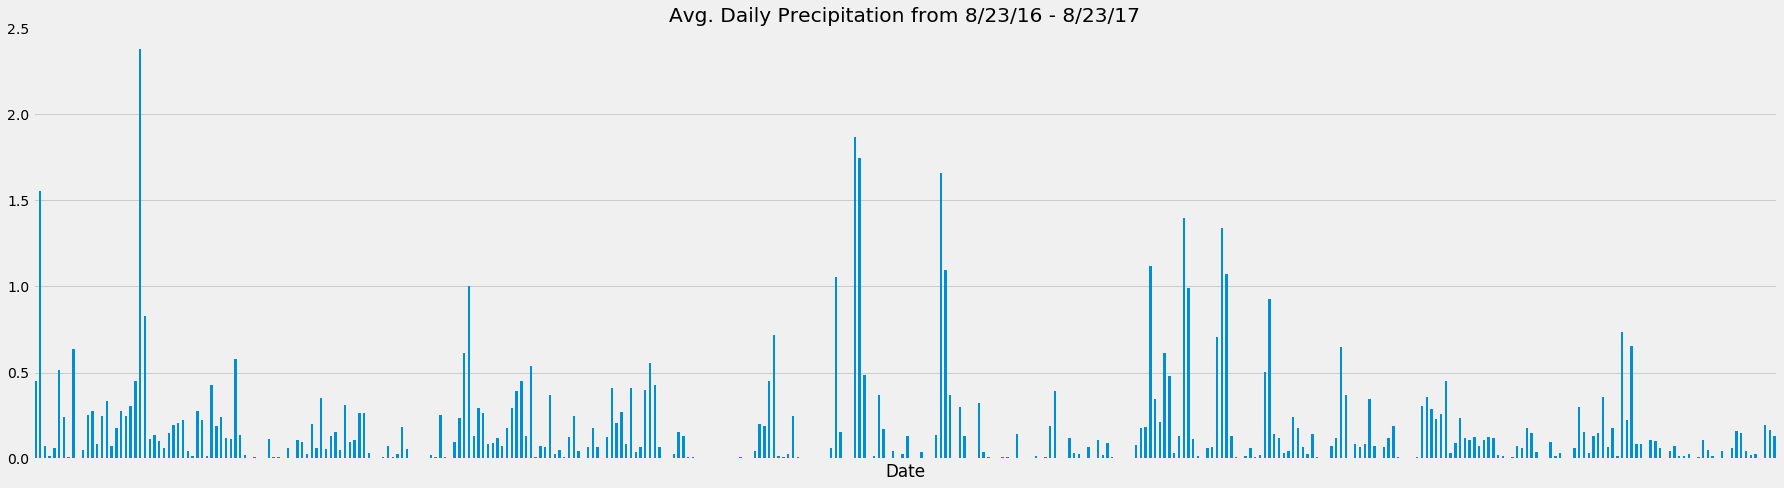

In [12]:
# USE PANDAS PLOTTING WITH MATPLOTLIB TO PLOT THE DATA
bar_plot = df.plot.bar(figsize=(25,7),title="Avg. Daily Precipitation from 8/23/16 - 8/23/17",legend=False)
plt.xticks([])
plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
plt.tight_layout()
plt.show()

In [13]:
# USE PANDAS TO CALCULATE THE SUMMARY STATISTICS FOR THE PRECIPITATION DATA
df.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Station Analysis

In [33]:
# DESIGN A QUERY TO SHOW HOW MANY STATIONS ARE AVAILABLE IN THIS DATASET
query = session.query(Station.station).distinct('station')
print(f"There are a total of {query.count()} stations in this dataset.")

There are a total of 9 stations in this dataset.


In [15]:
# WHAT IS THE MOST ACTIVE STATION?
# LIST THE STATIONS AND THE TEMPERATURE OBSERVATIONS IN DESCENDING ORDER.
sel = [Measurement.station, func.count(Measurement.tobs)]
query = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc())
query_df = pd.DataFrame(query, columns=['station_id','obs_count']).set_index('station_id')
max_station = query_df.index[0]
query_df

,obs_count
station_id,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
# USING THE STATION ID FROM THE PREVIOUS QUERY, CALCULATE THE LOWEST TEMPERATURE RECORDED,
# HIGHEST TEMPERATURE RECORDED, AND AVERAGE TEMPERATURE OF THE MOST ACTIVE STATION.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
query = session.query(*sel).\
    filter(Measurement.station == max_station).all()
query_df = pd.DataFrame(query, columns=['tmin','tavg','tmax'])
query_df

,tmin,tavg,tmax
0,54.0,85.0,71.663781


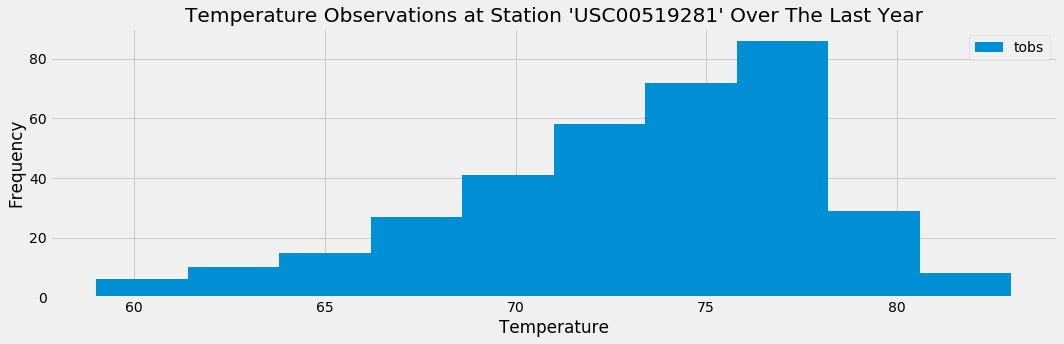

In [17]:
# CHOOSE THE STATION WITH THE HIGHEST NUMBER OF TEMPERATURE OBSERVATIONS.
# QUERY THE LAST 12 MONTHS OF TEMPERATURE OBSERVATION DATA FOR THIS STATION AND PLOT THE RESULTS AS A HISTOGRAM
sel = [Measurement.date, Measurement.tobs]
query = session.query(*sel).\
    filter(Measurement.station == max_station).\
    filter(func.strftime(Measurement.date) >= start_date).\
    group_by(Measurement.date).\
    order_by(func.count(Measurement.tobs).desc())
df = pd.DataFrame(query[:][:], columns=['date','tobs'])
df.plot.hist(figsize=(15,5), title = "Temperature Observations at Station 'USC00519281' Over The Last Year").set_xlabel("Temperature")
plt.tight_layout()

## Bonus: Other Recommended Analyses

In [18]:
# THE FOLLOWING ARE OPTIONAL CHALLENGE QUERIES.
# THESE ARE HIGHLY RECOMENDED TO ATTEMPT, BUT NOT REQUIRED FOR THE HOMEOWRK.

In [19]:
trip_start_previous_year = '2016-04-01'
trip_end_previous_year = '2016-04-20'

trip_start = '2017-04-01'
trip_end = '2017-04-20'

### Temperature Analysis I

In [20]:
# SELECT AVERAGE TEMPERATURES FOR ALL STATIONS IN JUNE.
sel = [Measurement.station, func.avg(Measurement.tobs)]
june_query = session.query(*sel).\
    filter(Measurement.date.like('%-06-%')).\
    group_by(Measurement.station)
june_df = pd.DataFrame(june_query, columns=['station_id','avg_temp']).set_index('station_id')

In [21]:
# SELECT AVERAGE TEMPERATURES FOR ALL STATIONS IN DECEMBER.
sel = [Measurement.station, func.avg(Measurement.tobs)]
december_query = session.query(*sel).\
    filter(Measurement.date.like('%-12-%')).\
    group_by(Measurement.station)
december_df = pd.DataFrame(december_query, columns=['station_id','avg_temp']).set_index('station_id')

In [22]:
temperature_df = june_df.merge(december_df, on='station_id', suffixes=['_june','_december'])
temperature_df

,avg_temp_june,avg_temp_december
station_id,,
USC00511918,74.139394,69.684211
USC00513117,74.050847,71.069444
USC00514830,76.005376,73.224719
USC00516128,71.937220,69.291262
USC00517948,76.655405,71.834862
USC00518838,73.394737,72.421053
USC00519281,73.271186,69.903226
USC00519397,77.559322,71.109524
USC00519523,76.668103,72.433333


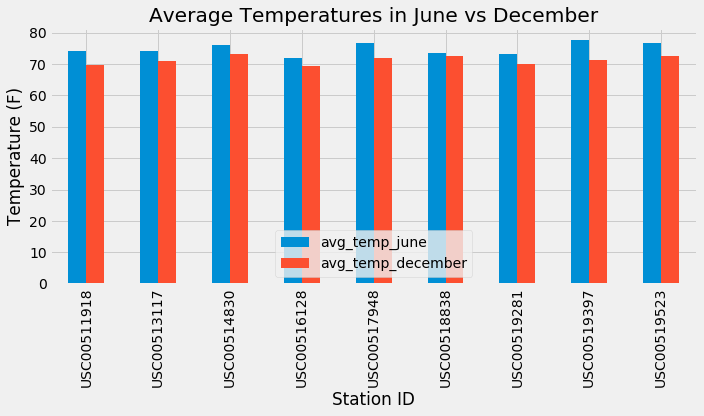

In [23]:
# USE PANDAS PLOTTING WITH MATPLOTLIB TO PLOT THE DATA
bar_plot = temperature_df.plot.bar(figsize=(10,6),title="Average Temperatures in June vs December")
plt.legend(loc='lower center',)
plt.xlabel('Station ID')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.show()

In [24]:
# JUNE STATIONS = DECEMBER STATIONS, SO PAIRED T-TEST
t, p = st.ttest_rel(temperature_df.avg_temp_june, temperature_df.avg_temp_december)
print(f"T-Value: {t}")
print(f"P-Value: {p}")
print("These results are statistically significant.")

T-Value: 6.95696617044294
P-Value: 0.00011759380231523222
The results are statistically significant.


### Temperature Analysis II

In [25]:
# THIS FUNCTION CALLED 'calc_temps' WILL ACCEPT START DATE AND END DATE IN THE FORMAT '%Y-%m-%d'
# AND RETURN THE MINIMUM, AVERAGE, AND MAXIMUM TEMPERATURES FOR THAT RANGE OF DATES
def calc_temps(start_date, end_date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# USE YOUR PREVIOUS FUNCTION 'calc_temps' TO CALCULATE THE TMIN, TAVG, AND TMAX
# FOR YOUR TRIP USING THE PREVIOUS YEAR'S DATA FOR THOSE SAME DATES.
query = calc_temps(trip_start_previous_year,trip_end_previous_year)
tmin = round(query[0][0],2)
tavg = round(query[0][1],2)
tmax = round(query[0][2],2)
_yerr = tmax-tmin
print(f"""Minimum Temperature During Previous Year's Trip Time: {tmin}.
Average Temperature During Previous Year's Trip Time: {tavg}.
Maximum Temperature During Previous Year's Trip Time: {tmax}.""")

Minimum Temperature During Previous Year's Trip Time: 65.0.
Average Temperature During Previous Year's Trip Time: 73.14.
Maximum Temperature During Previous Year's Trip Time: 80.0.


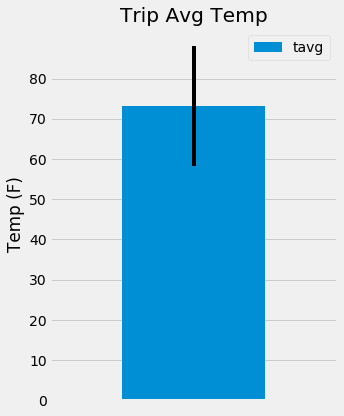

In [27]:
# PLOT THE RESULTS FROM YOUR PREVIOUS QUERY AS A BAR CHART.
# USE "TRIP AVG TEMP" AS YOUR TITLE
# USE THE AVERAGE TEMPERATURE FOR THE Y VALUE
# USE THE PEEK-TO-PEEK (TMAX-TMIN) VALUE AS THE Y ERROR BAR (YERR)
query_df = pd.DataFrame(query, columns=['tmin','tavg','tmax'])

query_df.plot.bar(y='tavg',yerr=_yerr,figsize=(5,6))
plt.xticks(np.arange(1, 1.0))
plt.yticks(np.arange(0, tmax+5, 10))
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.tight_layout()

In [28]:
# CALCULATE THE TOTAL AMOUNT OF RAINFALL PER WEATHER STATION FOR YOUR
# TRIP DATES USING THE PREVIOUS YEAR'S MATCHING DATES.

# SORT THIS IN DESCENDING ORDER BY PRECIPITATION AMOUNT AND LIST
# THE STATION, NAME, LATITUDE, LONGITUDE, AND ELEVATION.

# PERFORM A QUERY TO RETRIEVE THE DATA AND PRECIPITATION SCORES
sel = [Measurement.station, Station.name, 
       func.sum(Measurement.prcp), Station.latitude,
       Station.longitude, Station.elevation]

query = session.query(*sel).\
    filter(Station.station == Measurement.station,
           func.strftime(Measurement.date) >= trip_start_previous_year,
          func.strftime(Measurement.date) <= trip_end_previous_year).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc())
query_df = pd.DataFrame(query, columns=['station_id','station_name','total_rain','station_lat','station_long','station_elevation']).set_index('station_id')
query_df

,station_name,total_rain,station_lat,station_long,station_elevation
station_id,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",10.93,21.33310,-157.80250,152.4
USC00519281,"WAIHEE 837.5, HI US",4.13,21.45167,-157.84889,32.9
USC00513117,"KANEOHE 838.1, HI US",1.98,21.42340,-157.80150,14.6
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.99,21.52130,-157.83740,7.0
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.85,21.33556,-157.71139,19.5
USC00519397,"WAIKIKI 717.2, HI US",0.35,21.27160,-157.81680,3.0
USC00517948,"PEARL CITY, HI US",0.04,21.39340,-157.97510,11.9


In [29]:
# CREATE A QUERY THAT WILL CALCULATE THE DAILY NORMALS
# (I.E. THE AVERAGES FOR TMIN, TMAX, AND TAVG FOR ALL HISTORIC DATA MATCHING A SPECIFIC MONTH AND DAY)
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# CALCULATE THE DAILY NORMALS FOR YOUR TRIP
# PUSH EACH TUPLE OF CALCULATIONS INTO A LIST CALLED NORMALS

# SET THE START AND END DATE OF THE TRIP
start_date = datetime.datetime.strptime(trip_start, '%Y-%m-%d')
end_date = datetime.datetime.strptime(trip_end, '%Y-%m-%d')

# USE THE START AND END DATE TO CREATE A RANGE OF DATES
date_range = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date-start_date).days+1)]

# STRIP OFF THE YEAR AND SAVE A LIST OF %m-%d STRINGS
dates_stripped = [date_range[i].strftime('%m-%d') for i in range(len(date_range))]
dates_stripped

# LOOP THROUGH THE LIST OF %m-%d STRINGS AND CALCULATE THE NORMALS FOR EACH DATE
normals = [daily_normals(i) for i in dates_stripped]

In [34]:
# LOAD THE PREVIOUS QUERY RESULTS INTO A PANDAS DATAFRAME AND ADD THE 'trip_dates' RANGE AS THE 'date' INDEX
tmins = [normals[i][0][0] for i in range(len(normals))]
tavgs = [normals[i][0][1] for i in range(len(normals))]
tmaxs = [normals[i][0][2] for i in range(len(normals))]
tvals = list(zip(dates_stripped, tmins, tavgs, tmaxs))
trip_temperatures = pd.DataFrame(tvals, columns = ['DATES', 'TMINS', 'TAVGS', 'TMAXS']).set_index('DATES')
trip_temperatures

,TMINS,TAVGS,TMAXS
DATES,,,
04-01,60.0,71.879310,80.0
04-02,53.0,71.821429,79.0
04-03,55.0,72.228070,78.0
04-04,58.0,72.016393,78.0
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0


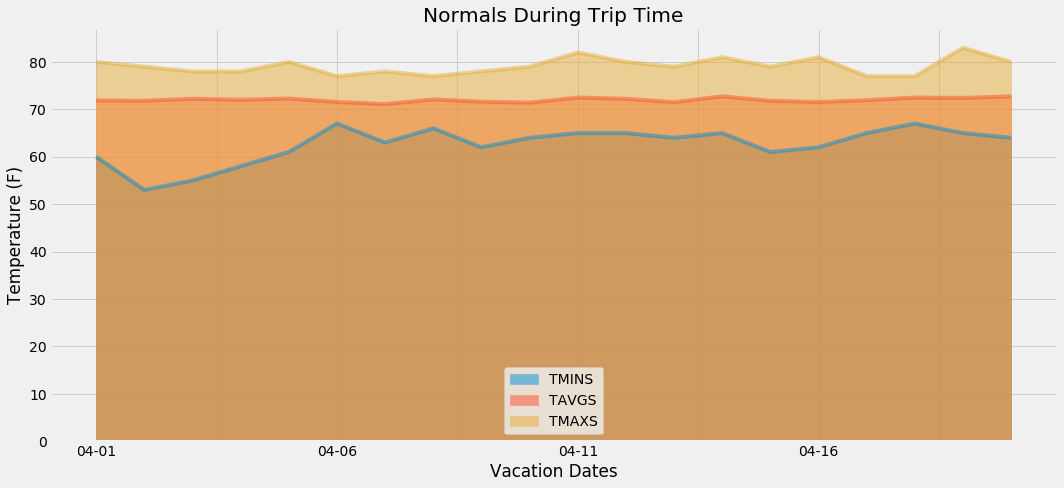

In [35]:
# PLOT THE DAILY NORMALS AS AN AREA PLOT WITH 'stacked=False'
area_plot = trip_temperatures.plot.area(stacked=False, figsize=(15,7), title='Normals During Trip Time')
plt.xlabel('Vacation Dates')
plt.ylabel('Temperature (F)')
plt.legend(loc='lower center')
plt.tight_layout()